## three-dimensional Rulkov Map Model (3DRMM)

In [2]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import time
import csv
import os


In [3]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%% Model: 3DRMM %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Based on Esther D. Gutierrez Non Chaotic Model code (Rulkov 2002)
# Version 4 designed by Luis Pabon-Orozco
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Developed on Arduino MEGA 2560 and UNO for physical viablility



class RulkovMapV4:
    """
    Creates a Rulkov Map model to apply three neuron coupling. Using diferent alpha values but equal sigma and g values.
    UPDATE V4: Use a simplified Rulkov Map Neuron. Using the same value for sigmas, initial values x and y, 
    and conductance g values. Use fixed betae value to 0.113
    """
    def __init__(self, alpha1=6, alpha2=6, alpha3=6, mu=0.001, sigma=0.3, g=0):
        """
        Initializes the model.

        Args:
            alpha1 (int, float): Non-Lineal variable alpha for neuron 1
            alpha2 (int, float): Non-Lineal Variable alpha for neuron 2
            alpha3 (int, float): Non-Lineal Variable alpha for neuron 3
            mu (int, float): Variable mu. Control of evolution of y, slow dynamic control.
            sigmas (int float): Initial value for sigma1, 2 and 3. Inter neural activation current.
            initialxy (int, float): Initial value for the membrane potential in neuron 1, 2 and 3. Initial value for the slow dynamics in neuron 1, 2 and 3.
            g (int, float): values for: gij Conductance between Neuron i and j.  Conductance between neurons terminals

            METHODS:

            *run: create temporal series for three neurons which have Ext. Currents created by Potential difference between Neuronal Membrane in axons
            *normalization_v2: Receive x1, x2, x3 from run.Return Signals x1,x2,x3 normalizated
            *grafic_X: Generate a X vs t time series graphic. Usually, 3DRMM uses 10k steps of iteration (each step~1ms). First 3000 steps are ignored because are part of stabilization period.
            *graf_normalization: Receive x1, x2, x3 normalizated and graph the temporal series.
            *silence_ver: Silence signal verificator. If a signal is complete zero, return 1. If has at least 1 non-zero value, return 0.
            *WLC Verificator: verifies WLC status in a normalized temporal series. If detects values over 1, means that exist two neurons in activity at same time.
            


        """
        #Inicialization
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.alpha3 = alpha3
        self.mu = mu
        self.sigma1 = sigma
        self.sigma2 = sigma
        self.sigma3 = sigma
        self.betae = None
        self.sigmae = None
        self.g12 = g
        self.g13 = g
        self.g23 = g
        self.x10 = None
        self.y10 = None
        self.x20 = None
        self.y20 = None
        self.x30 = None
        self.y30 = None
        self.beta12n = None
        self.beta13n = None
        self.beta21n = None
        self.beta23n = None
        self.beta31n = None
        self.beta32n = None
        self.sigma12n = None
        self.sigma13n = None
        self.sigma21n = None
        self.sigma23n = None
        self.sigma31n = None
        self.sigma32n = None
        self.t = None
        self.tevol = None
        self.status = " "
        self.cuad1=[]
        self.cuad2=[]
        self.cuad3=[]
        self.sum_cuad = []

    def __repr__(self):
        """
        Visualize model parameters when printing.
        """
        return f'RulkovModel(alpha1={self.alpha1}, alpha2={self.alpha2}, alpha3={self.alpha3}, mu={self.mu}, sigma1={self.sigma1}, sigma2={self.sigma2},sigma3={self.sigma3}, x10={self.x10}, y10= {self.y10},x20={self.x20}, y20= {self.y20},x30={self.x30}, y30= {self.y30}, g12={self.g12}, g13={self.g13}, g21={self.g21}, g23={self.g23}, g31={self.g31},g32={self.g32} betae={self.betae}, sigmae={self.sigmae}), cuad1={self.cuad1}, cuad2={self.cuad2}, cuad3={self.cuad3}, sum_cuad={self.sum_cuad}'

    def run(self, t=1000):
        """
        Run the model by iterating the system. Neuron i variables could be identified as xi, yi, ect.
        Args:

            t (int, optional): Total time for the simulation. Defaults to 1000.
        """
        self.t = t
        self.beta12n0=0
        self.beta13n0=0
        self.beta21n0=0
        self.beta23n0=0
        self.beta31n0=0
        self.beta32n0=0
        self.x10 = 0
        self.y10 = 0
        self.x20 = 0
        self.y20 = 0
        self.x30 = 0
        self.y30 = 0
        self.betae = 0.113 #fixed Value for RS neuron (Bazhelnov 2005)
        self.sigmae = 1
        self.tevol = np.arange(0, self.t)
        
        #Neuron 1
        self.x1 = np.zeros(self.tevol.shape)
        self.y1 = np.zeros(self.tevol.shape)
        self.beta12n = np.zeros(self.tevol.shape)
        self.beta13n = np.zeros(self.tevol.shape)
        self.sigma12n = np.zeros(self.tevol.shape)
        self.sigma13n = np.zeros(self.tevol.shape)

        #Neuron 2
        self.x2 = np.zeros(self.tevol.shape)
        self.y2 = np.zeros(self.tevol.shape)
        self.beta21n = np.zeros(self.tevol.shape)
        self.beta23n = np.zeros(self.tevol.shape)
        self.sigma21n = np.zeros(self.tevol.shape)
        self.sigma23n = np.zeros(self.tevol.shape)

        #Neuron 3
        self.x3 = np.zeros(self.tevol.shape)
        self.y3 = np.zeros(self.tevol.shape)
        self.beta31n = np.zeros(self.tevol.shape)
        self.beta32n = np.zeros(self.tevol.shape)
        self.sigma31n = np.zeros(self.tevol.shape)
        self.sigma32n = np.zeros(self.tevol.shape)


        #Initianizing signals
        self.x1[-1] = self.x10
        self.y1[-1] = self.y10
        self.x2[-1] = self.x20
        self.y2[-1] = self.y20
        self.x3[-1] = self.x30
        self.y3[-1] = self.y30
        self.beta12n[-1]=self.beta12n0
        self.beta13n[-1]=self.beta13n0
        self.beta21n[-1]=self.beta21n0
        self.beta23n[-1]=self.beta23n0
        self.beta31n[-1]=self.beta31n0
        self.beta32n[-1]=self.beta32n0

        for t in self.tevol:
          #gen of X1
            if self.x1[t - 1] <= 0:
                self.x1[t] = (self.alpha1 / (1 - self.x1[t - 1])) + self.y1[t - 1]+self.beta12n[t-1]+self.beta13n[t-1]

            elif ((0 < self.x1[t - 1] < self.alpha1 + self.y1[t - 1]+ self.beta12n[t-1]+self.beta13n[t-1])and(self.x1[t - 2]<= 0)):
                self.x1[t] = self.alpha1 + self.y1[t - 1]+self.beta12n[t-1]+self.beta13n[t-1]

            elif ((self.x1[t - 1] >= (self.alpha1 + self.y1[t - 1]+self.beta12n[t-1]+self.beta13n[t-1]))or(self.x1[t - 2] > 0)):
                self.x1[t] = -1

          #gen of X2
            if self.x2[t - 1] <= 0:
                self.x2[t] = (self.alpha2 / (1 - self.x2[t - 1])) + self.y2[t - 1]+self.beta21n[t-1]+self.beta23n[t-1]

            elif ((0 < self.x2[t - 1] < self.alpha2 + self.y2[t - 1]+ self.beta21n[t-1]+ self.beta23n[t-1])and(self.x2[t - 2]<= 0)):
                self.x2[t] = self.alpha2 + self.y2[t - 1]+self.beta21n[t-1]+self.beta23n[t-1]
                self.x2[t] = self.alpha2 + self.y2[t - 1]+self.beta21n[t-1]+self.beta23n[t-1]

            elif ((self.x2[t - 1] >= (self.alpha2 + self.y2[t - 1]+self.beta21n[t-1]+self.beta23n[t-1]))or (self.x2[t - 2] >0)):
                self.x2[t] = -1

            #Gen of X3
            if self.x3[t - 1] <= 0:
                self.x3[t] = (self.alpha3 / (1 - self.x3[t - 1])) + self.y3[t - 1]+self.beta31n[t-1] +self.beta32n[t-1]

            elif ((0 < self.x3[t - 1] < self.alpha3 + self.y3[t - 1]+ self.beta31n[t-1]+self.beta32n[t-1])and(self.x3[t - 2]<= 0)):
                self.x3[t] = self.alpha3 + self.y3[t - 1]+self.beta31n[t-1]+self.beta32n[t-1]

            elif ((self.x3[t - 1] >= (self.alpha3 + self.y3[t - 1]+self.beta31n[t-1]+self.beta32n[t-1]))or (self.x3[t - 2] >0)):
                self.x3[t] = -1

            #for neuron 1
            self.beta12n[t] = (self.g12*self.betae)*(self.x2[t]-self.x1[t])
            self.sigma12n[t] = (self.g12*self.sigmae)*(self.x2[t]-self.x1[t])
            self.beta13n[t] = (self.g13*self.betae)*(self.x3[t]-self.x1[t])
            self.sigma13n[t] = (self.g13*self.sigmae)*(self.x3[t]-self.x1[t])

            #for neuron 2
            self.beta21n[t] = (self.g12*self.betae)*(self.x1[t]-self.x2[t])
            self.sigma21n[t] = (self.g12*self.sigmae)*(self.x1[t]-self.x2[t])
            self.beta23n[t] = (self.g23*self.betae)*(self.x3[t]-self.x2[t])
            self.sigma23n[t] = (self.g23*self.sigmae)*(self.x3[t]-self.x2[t])

            #for neuron 2
            self.beta31n[t] = (self.g13*self.betae)*(self.x1[t]-self.x3[t])
            self.sigma31n[t] = (self.g13*self.sigmae)*(self.x1[t]-self.x3[t])
            self.beta32n[t] = (self.g23*self.betae)*(self.x2[t]-self.x3[t])
            self.sigma32n[t] = (self.g23*self.sigmae)*(self.x2[t]-self.x3[t])

            self.y1[t] = self.y1[t - 1] - (self.mu * (self.x1[t - 1] + 1)) + (self.mu*(self.sigma1 + self.sigma12n[t - 1] + self.sigma13n[t - 1]))
            self.y2[t] = self.y2[t - 1] - (self.mu * (self.x2[t - 1] + 1)) + (self.mu*(self.sigma2 + self.sigma21n[t - 1] + self.sigma23n[t - 1]))
            self.y3[t] = self.y3[t - 1] - (self.mu * (self.x3[t - 1] + 1)) + (self.mu*(self.sigma3 + self.sigma31n[t - 1] + self.sigma32n[t - 1]))

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Function normalization_v2:
#Receive x1, x2, x3 from run.
#Return Signals x1,x2,x3 normalizated

    def normalization_v2 (self):
        #*********************************
        #NEURON crop from 3000 to 10000 ms
        #*********************************
        #Neuron 1
        my_signal1 = self.x1
        signal1 = my_signal1[-7000:]
        #Neuron 2
        my_signal2 = self.x2
        signal2 = my_signal2[-7000:]
        #Neuron 3
        my_signal3 = self.x3
        signal3 = my_signal3[-7000:]
        #***********************************************************
        #Signal x1 Normalization: send all values between 0 and 1
        #***********************************************************
        s1_norm = (signal1 - np.min(signal1)) / (np.max(signal1) - np.min(signal1))
        # Bursting detection signal x1
        umbral_superior1 = 0.8  # Superior edge (must be, at least, 0.9)
        umbral_inferior1 = 0.1  # Inferior edge (very sensitive parameter. Must be equal to each signal. Fixed between 0.10 to 0.15)
        # Inicialization of starage buffers
        inicio_burstings1 = []
        fin_burstings1 = []
        # Bursting detection
        en_bursting1 = False  # Search variable for burst
        for i in range(len(s1_norm)):
            if s1_norm[i] > umbral_superior1 and not en_bursting1:
                inicio_burstings1.append(i)
                en_bursting1 = True
            elif s1_norm[i] < umbral_inferior1 and en_bursting1:
                fin_burstings1.append(i)
                en_bursting1 = False
        #Create a new square serie: 1 in bursting, 0 other values.
            serie_cuadrada1 = np.zeros(len(signal1))
        for inicio, fin in zip(inicio_burstings1, fin_burstings1):
            serie_cuadrada1[inicio:fin] = 1

        self.cuad1 = serie_cuadrada1

        #***********************************************************
        #Signal x2 Normalization: send all values between 0 and 1
        #***********************************************************
        s2_norm = (signal2 - np.min(signal2)) / (np.max(signal2) - np.min(signal2))

        # Bursting detection signal x2
        umbral_superior2 = 0.8  # Superior edge (must be, at least, 0.9)
        umbral_inferior2 = 0.1  # Inferior edge (very sensitive parameter. Must be equal to each signal. Fixed between 0.10 to 0.15)
        # Inicialization of starage buffers
        inicio_burstings2 = []
        fin_burstings2 = []
        # Bursting detection
        en_bursting2 = False  # Search variable for burst
        for i in range(len(s2_norm)):
            if s2_norm[i] > umbral_superior2 and not en_bursting2:
                inicio_burstings2.append(i)
                en_bursting2 = True
            elif s2_norm[i] < umbral_inferior2 and en_bursting2:
                fin_burstings2.append(i)
                en_bursting2 = False

        #Create a new square serie: 1 in bursting, 0 other values.
        serie_cuadrada2 = np.zeros(len(signal2))
        for inicio, fin in zip(inicio_burstings2, fin_burstings2):
            serie_cuadrada2[inicio:fin] = 1

        self.cuad2 = serie_cuadrada2

        #***********************************************************
        #Signal x3 Normalization: send all values between 0 and 1
        #***********************************************************
        s3_norm = (signal3 - np.min(signal3)) / (np.max(signal3) - np.min(signal3))

        # Bursting detection signal x3
        umbral_superior3 = 0.8  # Superior edge (must be, at least, 0.9)
        umbral_inferior3 = 0.1  # # Inferior edge (very sensitive parameter. Must be equal to each signal. Fixed between 0.10 to 0.15)

        # Inicialization of storage buffers
        inicio_burstings3 = []
        fin_burstings3 = []
        # Bursting detection
        en_bursting3 = False  # Search variable for burst
        for i in range(len(s3_norm)):
            if s3_norm[i] > umbral_superior3 and not en_bursting3:
                inicio_burstings3.append(i)
                en_bursting3 = True
            elif s3_norm[i] < umbral_inferior3 and en_bursting3:
                fin_burstings3.append(i)
                en_bursting3 = False

       #Create a new square serie: 1 in bursting, 0 other values.
        serie_cuadrada3 = np.zeros(len(signal3))
        for inicio, fin in zip(inicio_burstings3, fin_burstings3):
            serie_cuadrada3[inicio:fin] = 1

        self.cuad3 = serie_cuadrada3

        self.sum_cuad = (self.cuad1 + self.cuad2 +self.cuad3)
        

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Function grafic_X: 
#Generate a X (mV) vs t (ms) graphic. Usually, 3DRMM uses 10k steps 
#of iteration (each step~1ms). 
#First 3000 steps are ignored because are part of stabilization period.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    def grafic_X (self):
      fig,ax = plt.subplots(4,1,figsize=(8,6))
      ax[0].plot(self.x1[-7000:],label="$x^1$",color='b')
      ax[1].plot(self.x2[-7000:],label="$x^2$",color='r')
      ax[2].plot(self.x3[-7000:],label="$x^3$",color='g')
      ax[3].plot((self.x1[-7000:]+self.x2[-7000:]+self.x3[-7000:]) ,label="$x^{sum}$", color='grey')
      ax[0].legend()
      ax[1].legend()
      ax[2].legend()
      ax[3].legend()
      ax[3].set_xlabel("n")
      ax[0].set_ylabel("$x^1$")
      ax[1].set_ylabel("$x^2$")
      ax[2].set_ylabel("$x^3$")
      ax[3].set_ylabel("$x^{sum}$")
      plt.tight_layout()

      plt.show()    
        
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Function graf_normalization:
#Receive x1, x2, x3 normalizated and graph them
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def graf_normalization(self):
        
      fig,ax = plt.subplots(4,1,figsize=(8,6))
      ax[0].plot(self.cuad1,label=r"$\hat{x}^1$",color='b')
      ax[1].plot(self.cuad2,label=r"$\hat{x}^2$",color='r')
      ax[2].plot(self.cuad3,label=r"$\hat{x}^3$",color='g')
      ax[3].plot(self.sum_cuad ,label=r"$\hat{x}^{sum}$", color='grey')
      ax[0].legend()
      ax[1].legend()
      ax[2].legend()
      ax[3].legend()
      ax[3].set_xlabel("n")
      ax[0].set_ylabel("$x^1$")
      ax[1].set_ylabel("$x^2$")
      ax[2].set_ylabel("$x^3$")
      ax[3].set_ylabel("$x^{sum}$")
      plt.tight_layout()

      plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Function silence_ver: verifies if 
#after stabilization time, all temporal series is in silence
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def silence_ver(self):
      """
      Silence signal verificator. If a signal is complete zero,
      Return 1. If has at least 1 non-zero value, return 0.
      """
      allZero=0
      init=0
      fin= len(self.sum_cuad)
      
      for i in range(init,fin): #search zero in the last 6000 values of signal
        if (self.sum_cuad[i] > 0): #si el valor es diferente de cero,
            allZero=+1            #stat aumenta desde cero

      if (allZero==0): #If allZero never change, always zero in signal.
        return 1
      else:         #If allZero is diff of 0, means is not in silence status
        return 0
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Function WLC Verificator: verifies WLC status in a normalized 
#temporal series. If detects values over 1, means that exist two
#neurons in activity at same time.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    def ver_WLC_V1(self):
        change = 0  # Change count
        WLC = -4    # flag 
        rang0 = []  # Index where signal is over 1
        init = 1000  #first index in signal
        fin = len(self.sum_cuad)   # Final index in signal

        # Flag to verificate all signal is grounded (silent)
        all_zero = True  

        for i in range(init, fin):
            if self.sum_cuad[i] > 1:  # if two signals are active at same time
                change += 1000  #exist change
                all_zero = False  # means no silence state
            elif self.sum_cuad[i] > 0:  # If signal if between 0 and 1
                all_zero = False  # means no silence state
                rang0.append(i)
            else:  # If signal is 0
                rang0.append(i)

        if all_zero: #if three signals are silent, add change to not consider in WLC state.
            change += 1
        
        if change == 0: #if change never change, means neurons are not in silence and only one is active in any time.
            WLC = 1  # WLC confirmed
        else:
            WLC = 0  # WLC not exist for this configuration

        return WLC

    

### Signals generation, to visual verification of WLC state

Example: WLC


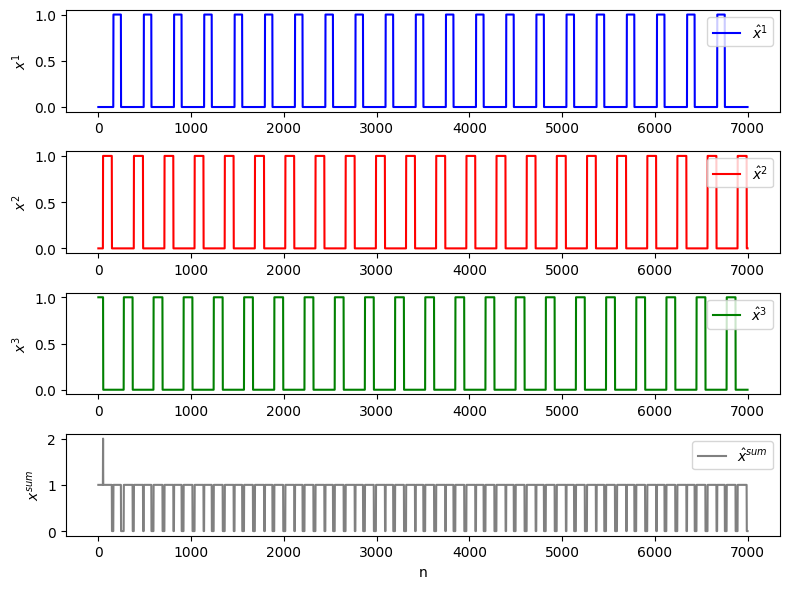

Example: NO WLC


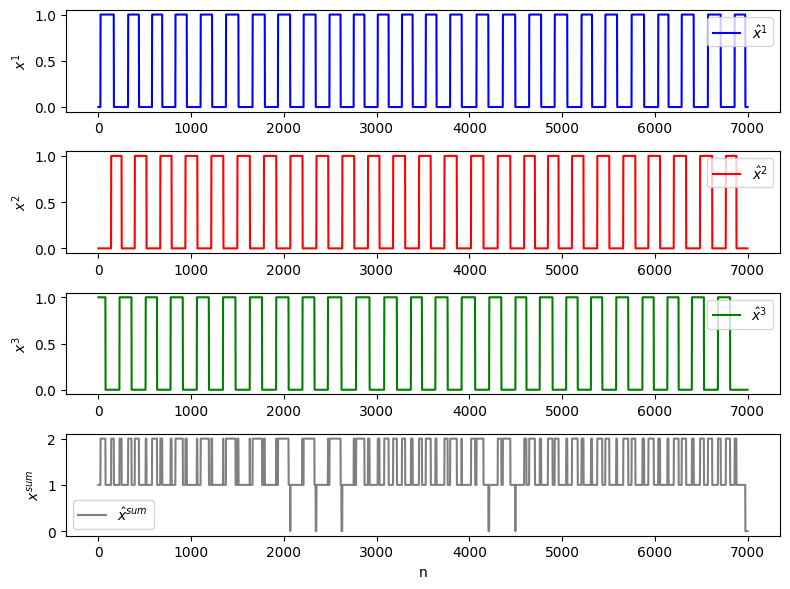

In [4]:
#Configuration 1: WLC exist.
N3= RulkovMapV4(alpha1=5.2, alpha2=5.3, alpha3=5.4, mu=0.001, sigma=-0.2, g=-0.04) 
#Configuration 1: WLC do not exist.
N32= RulkovMapV4(alpha1=5.2, alpha2=5.3, alpha3=5.4, mu=0.001, sigma=0, g=-0.04) 

print("Example: WLC")
N3.run(10000) #run model
N3.normalization_v2() #Normalization of x1,x2,x3
N3.graf_normalization() #graph x1,x2,x3,x sum
print("Example: NO WLC")
N32.run(10000) #run model
N32.normalization_v2() #Normalization of x1,x2,x3
N32.graf_normalization() #graph x1,x2,x3,x sum


### Manual Verificator

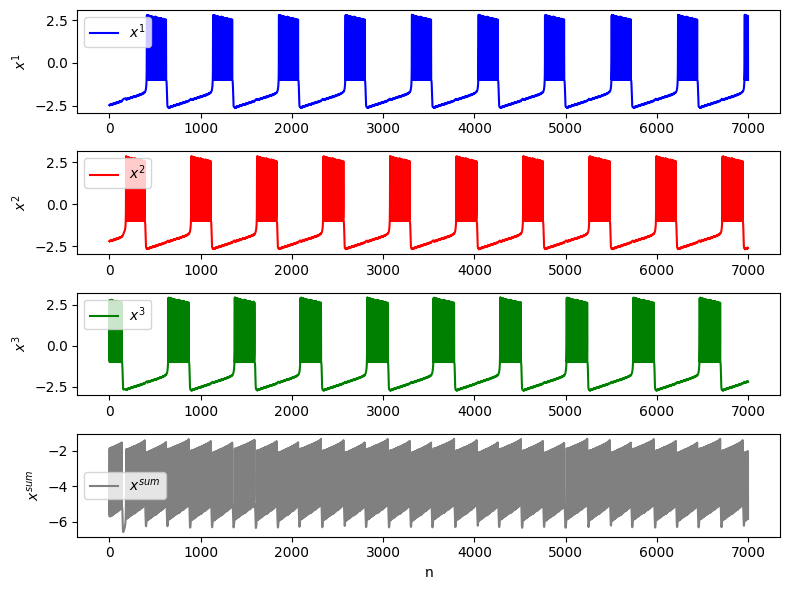

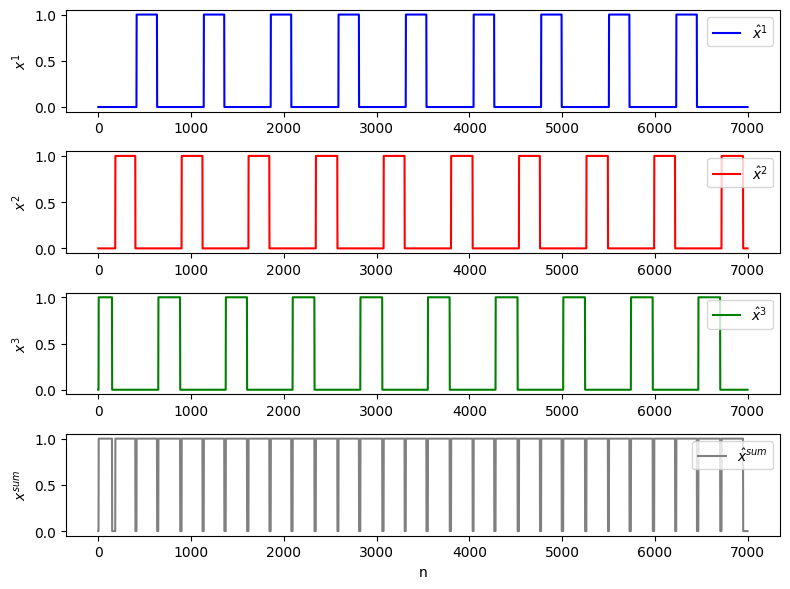

*************************************************************************
For this $lpha^i$, $\sigma^i$ and g values, WLC dynamic exists.
*************************************************************************


In [6]:
N3= RulkovMapV4(alpha1=7, alpha2=7.1, alpha3=7.2, mu=0.001, sigma=-0.5, g=-0.09)

N3.run(10000)
N3.grafic_X()
N3.normalization_v2()
N3.graf_normalization()
N3.silence_ver()
Z=N3.ver_WLC_V1()

print("*************************************************************************")
if (Z == 1):
    print("For this $\alpha^i$, $\sigma^i$ and g values, WLC dynamic exists.")
else:
    print("For this $\alpha^i$, $\sigma^i$ and g values, WLC dynamic NO exists.")
print("*************************************************************************")